# Data
- Lead scoring dataset from UCI
    - https://archive.ics.uci.edu/dataset/222/bank+marketing

# Methods
- Feature Engineering
    - One hot encoded categorical features
    - Scaled numerical features to have mean of 0 and variance of 1
    - Used SMOTE oversampling to generate more samples for the minority class
    - Features are binned using Chi-square tests
    - Information value (IV) calculated for the bins
    - Features with an IV over 0.1 are selected
- Model
    - Logistic regression trained on the data with the bins used as features
    - Scoring system created with a range of 0 to 100
    - Feature bins are assigned points, where more points are associated with a lead more likely to convert

In [1]:
import pandas as pd
import numpy as np
from optbinning import OptimalBinning, BinningProcess, Scorecard
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt
from optbinning.scorecard import plot_auc_roc
import seaborn as sns

In [2]:
df = pd.read_csv("data/raw/bank-additional/bank-additional-full.csv", delimiter=";")

In [3]:
df = df.drop(columns=["duration", "previous", "poutcome"])

In [4]:
cat_cols = ["job", "marital", "education", "default", 
            "housing", "loan", "contact", "month", 
            "day_of_week"]
num_cols = df.columns.difference(cat_cols + ["y"]).tolist()
for c in cat_cols:
    print(f"{c}: {len(df[c].unique())} categories")

job: 12 categories
marital: 4 categories
education: 8 categories
default: 3 categories
housing: 3 categories
loan: 3 categories
contact: 2 categories
month: 10 categories
day_of_week: 5 categories


In [5]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = ohe.fit_transform(df[cat_cols])
ohe_cat_features = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out().tolist())
data = pd.concat([df[num_cols], ohe_cat_features], axis=1)
y = df["y"].map(lambda x: 0 if x == "no" else 1)

In [6]:
sm = SMOTE()
x_sm, y_sm = sm.fit_resample(data, y)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.3)
ct = ColumnTransformer([
        ('scaler', StandardScaler(), num_cols)
    ], remainder='passthrough')

x_train_scaled = ct.fit_transform(x_train)
x_test_scaled = ct.transform(x_test)

In [11]:
x_train_scaled = pd.DataFrame(x_train_scaled, columns=data.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=data.columns)

In [12]:
# x = df[df.columns.difference(["y"])]
# y = df["y"].map(lambda x: 0 if x == "no" else 1)
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_sm, test_size=0.3)

selection_criteria = {"iv": {"min": 0.1, "max": 1}}
bins = BinningProcess(data.columns.to_list(), selection_criteria=selection_criteria)
model = LogisticRegression(class_weight="balanced")
scorecard = Scorecard(
    binning_process=bins,
    estimator=model,
    scaling_method="min_max",
    scaling_method_params={
        "min": 0,
        "max": 100
    },
    reverse_scorecard=True
)
scorecard.fit(x_train_scaled, y_train)

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.1}},
                                         variable_names=['age', 'campaign',
                                                         'cons.conf.idx',
                                                         'cons.price.idx',
                                                         'emp.var.rate',
                                                         'euribor3m',
                                                         'nr.employed', 'pdays',
                                                         'job_admin.',
                                                         'job_blue-collar',
                                                         'job_entrepreneur',
                                                         'job_housemaid',
                                                         'job_management',
                                                         'job_retired',
                                                         'job_self-employed',
                                                         'job_services',
                                                         'job_student',
                                                         'j...
                                                         'marital_divorced',
                                                         'marital_married',
                                                         'marital_single',
                                                         'marital_unknown',
                                                         'education_basic.4y',
                                                         'education_basic.6y',
                                                         'education_basic.9y',
                                                         'education_high.school',
                                                         'education_illiterate',
                                                         'education_professional.course', ...]),
          estimator=LogisticRegression(class_weight='balanced'),
          reverse_scorecard=True, scaling_method='min_max',
          scaling_method_params={'max': 100, 'min': 0})

In [18]:
pd.set_option('display.max_rows', 500)
scorecard.table()

,Variable,Bin,Points
0,age,"(-inf, -1.23)",3.853084
1,age,"[-1.23, -0.98)",3.329121
2,age,"[-0.98, -0.82)",2.938332
3,age,"[-0.82, -0.57)",2.738918
4,age,"[-0.57, -0.40)",2.554734
5,age,"[-0.40, -0.15)",2.472267
6,age,"[-0.15, 0.44)",2.288318
7,age,"[0.44, 0.77)",2.215135
8,age,"[0.77, 1.27)",2.635816
9,age,"[1.27, 1.60)",2.777004


0.8195325211113035


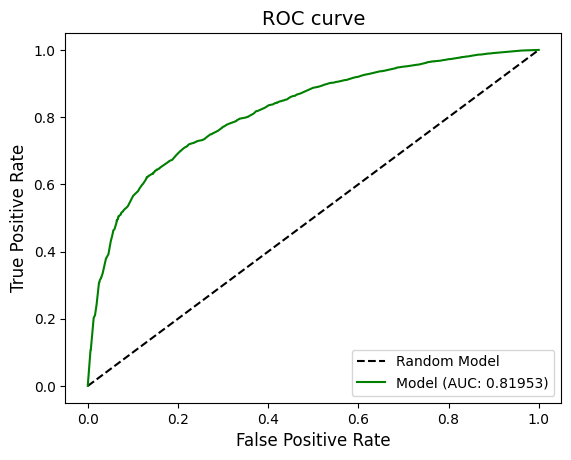

In [14]:
y_pred = scorecard.predict_proba(x_train)[:, 1]
print(roc_auc_score(y_train, y_pred))

plot_auc_roc(y_train, y_pred)

plt.show()

0.8159979373624788


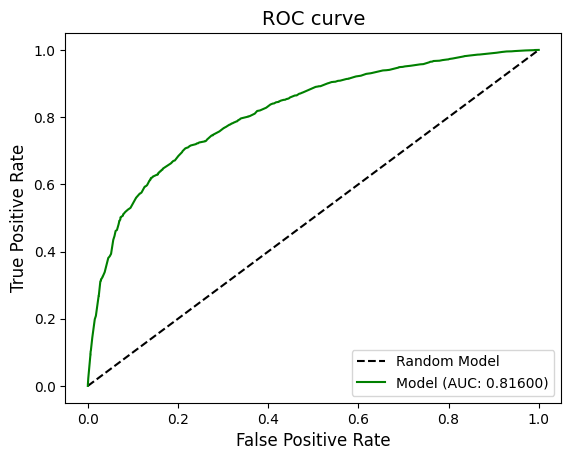

In [15]:
y_pred = scorecard.predict_proba(x_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

plot_auc_roc(y_test, y_pred)

plt.show()

<Axes: ylabel='Count'>

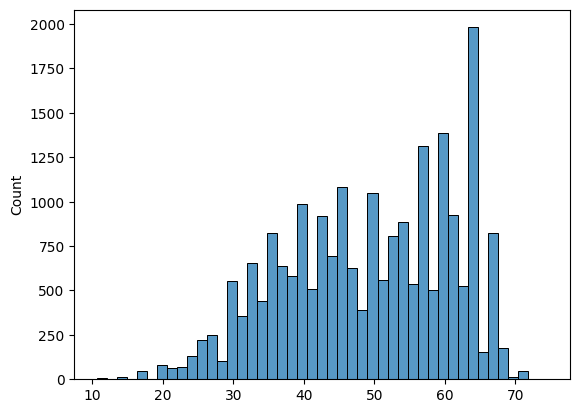

In [16]:
y_score = scorecard.score(x_test)
sns.histplot(y_score)

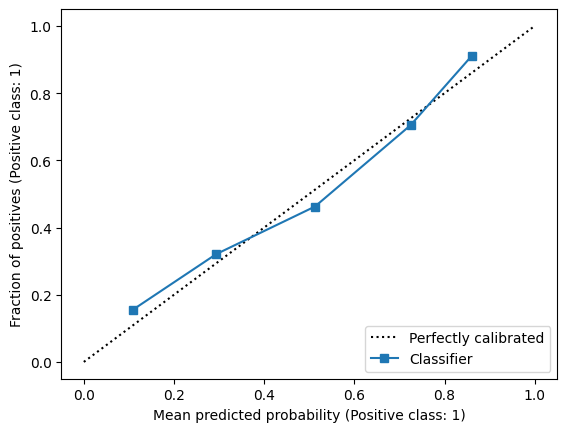

In [17]:
CalibrationDisplay.from_predictions(y_test, scorecard.predict_proba(x_test)[:, -1])